## Analysis notebook

### Imports

In [1]:
from bokeh.plotting import output_file, save
import json
import os
import pickle
from locpix_points.data_loading import datastruc
from locpix_points.scripts.visualise import visualise_torch_geometric, visualise_parquet, load_file
from locpix_points.scripts.featanalyse import (
    generate_umap_embedding,
    visualise_umap_embedding,
    generate_pca_embedding,
    visualise_pca_embedding,
    visualise_explanation,
    k_means_fn,
    get_prediction,
    subgraph_eval,
    pgex_eval,
    attention_eval,
)

import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
import umap
import yaml

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/root/micromamba/envs/locpix-points/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:21: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/root/micromamba/envs/locpix-points/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Functions

In [2]:
def find_graph_path(project_directory, file_name, file_folder):
    """Visualise raw data
    
    Args:
        project_directory (string): Location of project directory
        file_name (string) : Name of file to image
        file_folder (string) : Which folder the file is in"""
    
    train_file_map_path = os.path.join(project_directory, f"{file_folder}/train/file_map.csv")
    val_file_map_path = os.path.join(project_directory, f"{file_folder}/val/file_map.csv")
    test_file_map_path = os.path.join(project_directory, f"{file_folder}/test/file_map.csv")
    
    train_file_map = pd.read_csv(train_file_map_path)
    val_file_map = pd.read_csv(val_file_map_path)
    test_file_map = pd.read_csv(test_file_map_path)
    
    train_out = train_file_map[train_file_map["file_name"] == file_name]
    val_out = val_file_map[val_file_map["file_name"] == file_name]
    test_out = test_file_map[test_file_map["file_name"] == file_name]
    
    if len(train_out) > 0:
        folder = "train"
        file_name = train_out["idx"].values[0]
    if len(val_out) > 0:
        folder = "val"
        file_name = val_out["idx"].values[0]
    if len(test_out) > 0:
        folder = "test"
        file_name = test_out["idx"].values[0]
    
    return os.path.join(project_directory, f"{file_folder}/{folder}/{file_name}.pt")


### Parameters

In [3]:
project_directory = ".."
# load config
with open(os.path.join(project_directory, "config/featanalyse_manual.yaml"), "r") as ymlfile:
    config_manual = yaml.safe_load(ymlfile)
with open(os.path.join(project_directory, "config/featanalyse_nn.yaml"), "r") as ymlfile:
    config_nn = yaml.safe_load(ymlfile)
label_map = config_manual["label_map"]
assert label_map == config_nn["label_map"]
manual_features = config_manual["features"]

In [4]:
final_test = True
umap_n_neighbours = 20
umap_min_dist = 0.5
pca_n_components = 2
device = 'cuda'

## Analyse the nn features

In [5]:
train_df_nn_loc = os.path.join(project_directory, "output/train_df_nn_loc.csv")
train_df_nn_loc = pd.read_csv(train_df_nn_loc)

train_df_nn_cluster = os.path.join(project_directory, "output/train_df_nn_cluster.csv")
train_df_nn_cluster = pd.read_csv(train_df_nn_cluster)

train_df_nn_fov = os.path.join(project_directory, "output/train_df_nn_fov.csv")
train_df_nn_fov = pd.read_csv(train_df_nn_fov)

if final_test:  
    test_df_nn_loc = os.path.join(project_directory, "output/test_df_nn_loc.csv")
    test_df_nn_loc = pd.read_csv(test_df_nn_loc)

    test_df_nn_cluster = os.path.join(project_directory, "output/test_df_nn_cluster.csv")
    test_df_nn_cluster = pd.read_csv(test_df_nn_cluster)

    test_df_nn_fov = os.path.join(project_directory, "output/test_df_nn_fov.csv")
    test_df_nn_fov = pd.read_csv(test_df_nn_fov)

else:
    test_df_nn_loc = None
    test_df_nn_cluster = None
    test_df_nn_fov = None


### Graph feature explainability

In [6]:
def prep_features(train_df, test_df):

    # get features present in the dataframe
    not_features = ["type", "file_name"]
    features = [x for x in train_df.columns.to_list() if x not in not_features]

    # feature vector
    train_data_feats_nn = train_df[features].values
    if final_test:
        test_data_feats_nn = test_df[features].values

    num_features = len(train_data_feats_nn[0])
    print("Num features: ", num_features)
    ############ WARNING ##############
    # Be careful, if analysing neural net features
    # Is this the number of features you expect
    # Did this task use manual features as well

    scaler = StandardScaler().fit(train_data_feats_nn)
    X_train_nn = scaler.transform(train_data_feats_nn)
    if final_test:
        X_test_nn = scaler.transform(test_data_feats_nn)
        
        return X_train_nn, X_test_nn
    else:
        return X_train_nn, None

X_train_nn_loc, X_test_nn_loc = prep_features(train_df_nn_loc, test_df_nn_loc)
X_train_nn_cluster, X_test_nn_cluster = prep_features(train_df_nn_cluster, test_df_nn_cluster)
X_train_nn_fov, X_test_nn_fov = prep_features(train_df_nn_fov, test_df_nn_fov)

Num features:  8
Num features:  40
Num features:  40


#### UMAP

In [7]:
train_umap_embedding_nn_loc_path = os.path.join(project_directory, "output/train_umap_embedding_nn_loc.pkl")
train_umap_embedding_nn_cluster_path = os.path.join(project_directory, "output/train_umap_embedding_nn_cluster.pkl")
train_umap_embedding_nn_fov_path = os.path.join(project_directory, "output/train_umap_embedding_nn_fov.pkl")

test_umap_embedding_nn_loc_path = os.path.join(project_directory, "output/test_umap_embedding_nn_loc.pkl")
test_umap_embedding_nn_cluster_path = os.path.join(project_directory, "output/test_umap_embedding_nn_cluster.pkl")
test_umap_embedding_nn_fov_path = os.path.join(project_directory, "output/test_umap_embedding_nn_fov.pkl")

#if not os.path.exists(train_umap_embedding_nn_loc_path):
#    train_umap_embedding_nn_loc = generate_umap_embedding(X_train_nn_loc, umap_min_dist, umap_n_neighbours)
#    with open(train_umap_embedding_nn_loc_path, "wb") as f:
#        pickle.dump(train_umap_embedding_nn_loc, f)
#    f.close()
#if not os.path.exists(train_umap_embedding_nn_cluster_path):
#    train_umap_embedding_nn_cluster = generate_umap_embedding(X_train_nn_cluster, umap_min_dist, umap_n_neighbours)
#    with open(train_umap_embedding_nn_cluster_path, "wb") as f:
#        pickle.dump(train_umap_embedding_nn_cluster, f)
#    f.close()
#if not os.path.exists(train_umap_embedding_nn_fov_path):
#    train_umap_embedding_nn_fov = generate_umap_embedding(X_train_nn_fov, umap_min_dist, umap_n_neighbours)
#    with open(train_umap_embedding_nn_fov_path, "wb") as f:
#        pickle.dump(train_umap_embedding_nn_fov, f)
#    f.close()
if final_test:
    if not os.path.exists(test_umap_embedding_nn_loc_path):
        test_umap_embedding_nn_loc = generate_umap_embedding(X_test_nn_loc, umap_min_dist, umap_n_neighbours)
        with open(test_umap_embedding_nn_loc_path, "wb") as f:
            pickle.dump(test_umap_embedding_nn_loc, f)
        f.close()
    
    if not os.path.exists(test_umap_embedding_nn_cluster_path):
        test_umap_embedding_nn_cluster = generate_umap_embedding(X_test_nn_cluster, umap_min_dist, umap_n_neighbours)
        with open(test_umap_embedding_nn_cluster_path, "wb") as f:
            pickle.dump(test_umap_embedding_nn_cluster, f)
        f.close()

    if not os.path.exists(test_umap_embedding_nn_fov_path):
        test_umap_embedding_nn_fov = generate_umap_embedding(X_test_nn_fov, umap_min_dist, umap_n_neighbours)
        with open(test_umap_embedding_nn_fov_path, "wb") as f:
            pickle.dump(test_umap_embedding_nn_fov, f)
        f.close()

In [ ]:
print("------ LOC ENCODER -------")
#with open(train_umap_embedding_nn_loc_path, "rb") as f:
#        train_umap_embedding_nn_loc = pickle.load(f)
#visualise_umap_embedding(train_umap_embedding_nn_loc, train_df_nn_loc, label_map)
if final_test:
    with open(test_umap_embedding_nn_loc_path, "rb") as f:
        test_umap_embedding_nn_loc = pickle.load(f)
    visualise_umap_embedding(test_umap_embedding_nn_loc, test_df_nn_loc, label_map, save=True, save_name="nn_loc_encoder_umap_nn_20_mindist_0.5", project_directory=project_directory, point_size=0.001)


In [ ]:
print("------ CLUSTER ENCODER -------")
#with open(train_umap_embedding_nn_cluster_path, "rb") as f:
#        train_umap_embedding_nn_cluster = pickle.load(f)
#visualise_umap_embedding(train_umap_embedding_nn_cluster, train_df_nn_cluster, label_map)
if final_test:
    with open(test_umap_embedding_nn_cluster_path, "rb") as f:
            test_umap_embedding_nn_cluster = pickle.load(f)
    visualise_umap_embedding(test_umap_embedding_nn_cluster, test_df_nn_cluster, label_map, save=True, save_name="nn_cluster_encoder_umap_nn_20_mindist_0.5", project_directory=project_directory, point_size=0.001)

In [11]:
print("------ FOV ENCODER -------")
#with open(train_umap_embedding_nn_fov_path, "rb") as f:
#        train_umap_embedding_nn_fov = pickle.load(f)
#visualise_umap_embedding(train_umap_embedding_nn_fov, train_df_nn_fov, label_map)
if final_test:
    with open(test_umap_embedding_nn_fov_path, "rb") as f:
        test_umap_embedding_nn_fov = pickle.load(f)
    plot = visualise_umap_embedding(test_umap_embedding_nn_fov, 
                                    test_df_nn_fov, 
                                    label_map, 
                                    save=False, 
                                    save_name="nn_fov_encoder_umap_nn_20_mindist_0.5", 
                                    project_directory=project_directory, 
                                    interactive=True, 
                                    point_size=5)
    if True:
        output_file_loc  = os.path.join(project_directory, "output", "nn_fov.html")
        output_file(output_file_loc)
        save(plot)

------ FOV ENCODER -------


Loading BokehJS ...

Start : This command cannot be run due to the error: The system cannot find the file specified.
At line:1 char:1
+ Start "/home/oliver/smlm_cloud/locpix-points/digits_letters/task_2_fi ...
+ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    + CategoryInfo          : InvalidOperation: (:) [Start-Process], InvalidOperationException
    + FullyQualifiedErrorId : InvalidOperationException,Microsoft.PowerShell.Commands.StartProcessCommand
 


#### PCA

In [ ]:
train_pca_embedding_nn_loc = generate_pca_embedding(X_train_nn_loc, pca_n_components)
train_pca_embedding_nn_fov = generate_pca_embedding(X_train_nn_fov, pca_n_components)
train_pca_embedding_nn_cluster = generate_pca_embedding(X_train_nn_cluster, pca_n_components)
if final_test:
    test_pca_embedding_nn_loc = generate_pca_embedding(X_test_nn_loc, pca_n_components)
    test_pca_embedding_nn_fov = generate_pca_embedding(X_test_nn_fov, pca_n_components)
    test_pca_embedding_nn_cluster = generate_pca_embedding(X_test_nn_cluster, pca_n_components)

In [ ]:
print("------ LOC ENCODER -------")
visualise_pca_embedding(train_pca_embedding_nn_loc, train_df_nn_loc, label_map)
if final_test:
    visualise_pca_embedding(test_pca_embedding_nn_loc, test_df_nn_loc, label_map)

In [ ]:
print("------ CLUSTER ENCODER -------")
visualise_pca_embedding(train_pca_embedding_nn_cluster, train_df_nn_cluster, label_map)
if final_test:
    visualise_pca_embedding(test_pca_embedding_nn_cluster, test_df_nn_cluster, label_map)


In [ ]:
print("------ FOV ENCODER -------")
visualise_pca_embedding(train_pca_embedding_nn_fov, train_df_nn_fov, label_map)
if final_test:
    visualise_pca_embedding(test_pca_embedding_nn_fov, test_df_nn_fov, label_map)

#### K-means

In [ ]:
print("----- LOC ------")
k_means_fn(X_train_nn_loc, train_df_nn_loc, label_map)
if final_test:
    k_means_fn(X_test_nn_loc, test_df_nn_loc, label_map)

print("----- CLUSTER ------")
k_means_fn(X_train_nn_cluster, train_df_nn_cluster, label_map)
if final_test:
    k_means_fn(X_test_nn_cluster, test_df_nn_cluster, label_map)

print("----- FOV ------")
k_means_fn(X_train_nn_fov, train_df_nn_fov, label_map)
if final_test:
    k_means_fn(X_test_nn_fov, test_df_nn_fov, label_map)


### Graph structure explainability

In [6]:
# get item to evaluate on
file_name = "L_102"

#### Load in configuration

In [14]:
config_path = os.path.join(project_directory, "config/featanalyse_nn.yaml")
with open(config_path, "r") as ymlfile:
    config = yaml.safe_load(ymlfile)

# load in gt_label_map
metadata_path = os.path.join(project_directory, "metadata.json")
with open(
    metadata_path,
) as file:
    metadata = json.load(file)
    # add time ran this script to metadata
    gt_label_map = metadata["gt_label_map"]

gt_label_map = {int(key): val for key, val in gt_label_map.items()}

#### Visualise raw file

In [8]:
if not final_test:
    file_folder = "preprocessed/gt_label"
else:
    file_folder = "preprocessed/test/gt_label"
file_path = os.path.join(project_directory, file_folder, file_name + ".parquet")
visualise_parquet(file_path, 'x', 'y', None, 'channel', {0: "channel_0", 1: "channel_1", 2: "channel_2", 3: "channel_3"}, cmap=['k'], spheres=True, sphere_size=0.004)

Channel 0 is channel_0 is colour k to remove use K


#### Visualise file

In [123]:
if not final_test:
    fold = config["fold"]
    file_folder = f"processed/fold_{fold}"
else:
    file_folder = "processed"
file_loc = find_graph_path(project_directory, file_name, file_folder)
visualise_torch_geometric(file_loc)

Channel 0 is locs is colour r to remove use K
Channel 1 is clusters is colour darkorange to remove use R


#### Load in cluster model

In [6]:
cluster_model = torch.load(os.path.join(project_directory, f"output/cluster_model.pt"))
cluster_model.to(device)
cluster_model.eval()

ClusterNetHomogeneous(
  (cluster_encoder_0): PointTransformerConv(8, 16)
  (cluster_encoder_1): PointTransformerConv(16, 24)
  (cluster_encoder_2): PointTransformerConv(24, 32)
  (cluster_encoder_3): PointTransformerConv(32, 40)
  (linear): Linear(in_features=40, out_features=7, bias=True)
  (pool): MaxAggregation()
)

#### Load datasets

In [7]:
cluster_train_folder = os.path.join(project_directory, "processed/featanalysis/train")
cluster_val_folder = os.path.join(project_directory, "processed/featanalysis/val")
cluster_test_folder = os.path.join(project_directory, "processed/featanalysis/test")

if not final_test:
    loc_test_folder = os.path.join(
        project_directory, "processed", f"fold_{fold}", "test"
    )
    loc_train_folder = os.path.join(
        project_directory, "processed", f"fold_{fold}", "train"
    )
    loc_val_folder = os.path.join(
        project_directory, "processed", f"fold_{fold}", "val"
    )

else:
    loc_test_folder = os.path.join(project_directory, "processed", "test")
    loc_train_folder = os.path.join(project_directory, "processed", "train")
    loc_val_folder = os.path.join(project_directory, "processed", "val")


cluster_train_set = datastruc.ClusterDataset(
    None,
    cluster_train_folder,
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    fov_x=None,
    fov_y=None,
)

cluster_val_set = datastruc.ClusterDataset(
    None,
    cluster_val_folder,
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    fov_x=None,
    fov_y=None,
)

cluster_test_set = datastruc.ClusterDataset(
    None,
    cluster_test_folder,
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    fov_x=None,
    fov_y=None,
)

# localisations are yet to be passed through any network

loc_train_set = datastruc.ClusterLocDataset(
    None,  # raw_loc_dir_root
    None,  # raw_cluster_dir_root
    loc_train_folder,  # processed_dir_root
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    loc_feat=None,
    cluster_feat=None,
    min_feat_locs=None,
    max_feat_locs=None,
    min_feat_clusters=None,
    max_feat_clusters=None,
    kneighboursclusters=None,
    fov_x=None,
    fov_y=None,
    kneighbourslocs=None,
)

loc_val_set = datastruc.ClusterLocDataset(
    None,  # raw_loc_dir_root
    None,  # raw_cluster_dir_root
    loc_val_folder,  # processed_dir_root
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    loc_feat=None,
    cluster_feat=None,
    min_feat_locs=None,
    max_feat_locs=None,
    min_feat_clusters=None,
    max_feat_clusters=None,
    kneighboursclusters=None,
    fov_x=None,
    fov_y=None,
    kneighbourslocs=None,
)

loc_test_set = datastruc.ClusterLocDataset(
    None,  # raw_loc_dir_root
    None,  # raw_cluster_dir_root
    loc_test_folder,  # processed_dir_root
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    loc_feat=None,
    cluster_feat=None,
    min_feat_locs=None,
    max_feat_locs=None,
    min_feat_clusters=None,
    max_feat_clusters=None,
    kneighboursclusters=None,
    fov_x=None,
    fov_y=None,
    kneighbourslocs=None,
)


/home/oliver/smlm_cloud/others/pytorch_geometric/torch_geometric/data/dataset.py:222: UserWarning: The `pre_filter` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-fitering technique, make sure to delete '{self.processed_dir}' first
  warnings.warn(


#### Get items to evaluate on 

In [141]:
cluster_dataitem, loc_dataitem, prediction = get_prediction(
    file_name,
    cluster_model, 
    cluster_train_set, 
    loc_train_set, 
    cluster_val_set, 
    loc_val_set, 
    cluster_test_set, 
    loc_test_set,
    project_directory,
    device, 
    gt_label_map)

-----
Predicted label:  T
GT label:  L


#### SubgraphX

In [21]:
subgraph_config = {
    # number of iterations to get prediction
    "rollout": 20,
    # number of atoms of leaf node in search tree
    "min_atoms": 5,
    # hyperparameter that encourages exploration
    "c_puct": 10.0,
    # number of atoms to expand when extend the child nodes in the search tree
    "expand_atoms": 14,
    # whether to expand the children nodes from high degreee to low degree when extend the child nodes in the search tree
    "high2low": False,
    # number of local radius to caclulate
    "local_radius": 4,
    # sampling time of montecarlo approxim
    "sample_num": 100,
    # reward method
    "reward_method": "mc_l_shapley",
    # subgrpah building method
    "subgraph_building_method": "split",
    # maximum number of nodes to include in subgraph when generating explanation
    "max_nodes": 8,
    # number of classes
    "num_classes": 7,
}

In [143]:
 # ---- subgraphx -----
_, _, cluster_dataitem, node_imp = subgraph_eval(cluster_model, device, subgraph_config, cluster_dataitem, prediction)
    

Subgraphx...
Sparsity: 0.5116
Accuracy: nan
Stability: nan
Contains self loops:  True
Add/Remove edges using R button
Add/Remove positive nodes using T button
Add/Remove negative nodes using Y button


/home/oliver/smlm_cloud/locpix-points/src/locpix_points/scripts/featanalyse.py:1498: UserWarning: The edge mask is directional, meaning an edge from node 0 to 1 may be significant while an edge from 1 to 0 may not be. For visualisation we make the graph undirected and we take the maximum of two edges that connect two nodes
  warnings.warn(


Positive fidelity tensor([0.9959], device='cuda:0', grad_fn=<AbsBackward0>)
Negative fidelity tensor([0.0024], device='cuda:0', grad_fn=<AbsBackward0>)


In [145]:
# visualise overlaid subgraph

if not final_test:
    fold = config["fold"]
    file_folder = f"processed/fold_{fold}"
else:
    file_folder = "processed"
file_loc = find_graph_path(project_directory, file_name, file_folder)

visualise_explanation(
    cluster_dataitem.pos,
    cluster_dataitem.edge_index,
    node_imp=node_imp.to(device),
    edge_imp=None,
    overlay=True,
    file_loc=file_loc, 
)

/home/oliver/smlm_cloud/locpix-points/src/locpix_points/scripts/featanalyse.py:1498: UserWarning: The edge mask is directional, meaning an edge from node 0 to 1 may be significant while an edge from 1 to 0 may not be. For visualisation we make the graph undirected and we take the maximum of two edges that connect two nodes
  warnings.warn(
/home/oliver/smlm_cloud/locpix-points/src/locpix_points/scripts/featanalyse.py:1697: UserWarning: Localisations will be slightly set back from graph
  warnings.warn("Localisations will be slightly set back from graph")


Contains self loops:  True
Add/Remove edges using R button
Add/Remove positive nodes using T button
Add/Remove negative nodes using Y button


#### PgEx

In [131]:
pgex_config = {
    # threshold to apply to edge mask for pyg explain
    "edge_mask_threshold": 0.9999,
}

In [132]:
# ---- pgexplainer ----
pg_explainer = torch.load(os.path.join(project_directory, f"output/pg_explainer.pt")) 
pgex_eval(cluster_model, pg_explainer, cluster_dataitem, device, pgex_config)

Warning there are 79 non zero elements in the edge mask out of 79 elements
Post thresholding there are 79 non zero elements in the edge mask out of 79 elements
Unfaithfulness, closer to 0 better 0.0
Contains self loops:  True
Add/Remove positive edges using R button
Add/Remove negative edges using K button
Add/Remove nodes using T button
[Open3D WARNING] [SimpleShaderForLineSet] Binding failed with empty geometry::LineSet.
[Open3D WARNING] [SimpleShaderForLineSet] Binding failed when preparing data.
[Open3D WARNING] [SimpleShaderForLineSet] Something is wrong in compiling or binding.


ValueError: No complement graph as induced subgraph is the whole graph

#### Attention

In [133]:
attention_config = {
    #  scale: cluster # Options: [cluster] In future will also include [loc, loccluster]
    "scale": "cluster",
    #  # how to combine attention scores across multiple attention heads
    "reduce": "max",
    # threshold to apply to edge mask for pyg explain
    "edge_mask_threshold": 0.5,
}

In [134]:
# ---- attention -----
# use model - logprobs or clustermodel - raw
attention_eval(cluster_model, attention_config, cluster_dataitem, device, loc_dataitem)

Warning there are 79 non zero elements in the edge mask out of 79 elements
Post thresholding there are 24 non zero elements in the edge mask out of 79 elements
Unfaithfulness, closer to 0 better 0.9999999570561009
Contains self loops:  True
Add/Remove positive edges using R button
Add/Remove negative edges using K button
Add/Remove nodes using T button


ValueError: No complement graph as induced subgraph is the whole graph

### Identify incorrectly predicted points in the UMAP for the test

In [44]:
files = plot.renderers[0].data_source.data["file_name"]
files = [x.removesuffix('.parquet') for x in files]

wrong_files = []
for file in files:
    file_name = file
    x, _, pred = cluster_dataitem, loc_dataitem, prediction = get_prediction(
        file_name,
        cluster_model, 
        cluster_train_set, 
        loc_train_set, 
        cluster_val_set, 
        loc_val_set, 
        cluster_test_set, 
        loc_test_set,
        project_directory,
        device, 
        gt_label_map)
    if x.y.detach().item() != pred:
        wrong_files.append(x.name)

new_colors = ["#000000"]*len(files)
for id, file in enumerate(files):
    if file in wrong_files:
        new_colors[id] = "#FF0000"

-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  T
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  T
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L
GT label:  L
-----
Predicted label:  L

In [45]:
plot.renderers[0].data_source.data["new_colors"] = new_colors
plot.renderers[0].glyph.fill_color = 'new_colors'
plot.renderers[0].glyph.line_color = 'new_colors'
umap.plot.show(plot)

Start : This command cannot be run due to the error: The system cannot find the file specified.
At line:1 char:1
+ Start "/home/oliver/smlm_cloud/locpix-points/digits_letters/task_2_fi ...
+ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    + CategoryInfo          : InvalidOperation: (:) [Start-Process], InvalidOperationException
    + FullyQualifiedErrorId : InvalidOperationException,Microsoft.PowerShell.Commands.StartProcessCommand
 


### Statistical tests

### Publication figures

In [9]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from torch_geometric.utils.convert import to_networkx
import networkx as nx
from networkx.drawing import draw_networkx, draw
import numpy as np


In [10]:
files = ["three_1933", "one_2924", "L_680", "L_102"]

#### Raw files

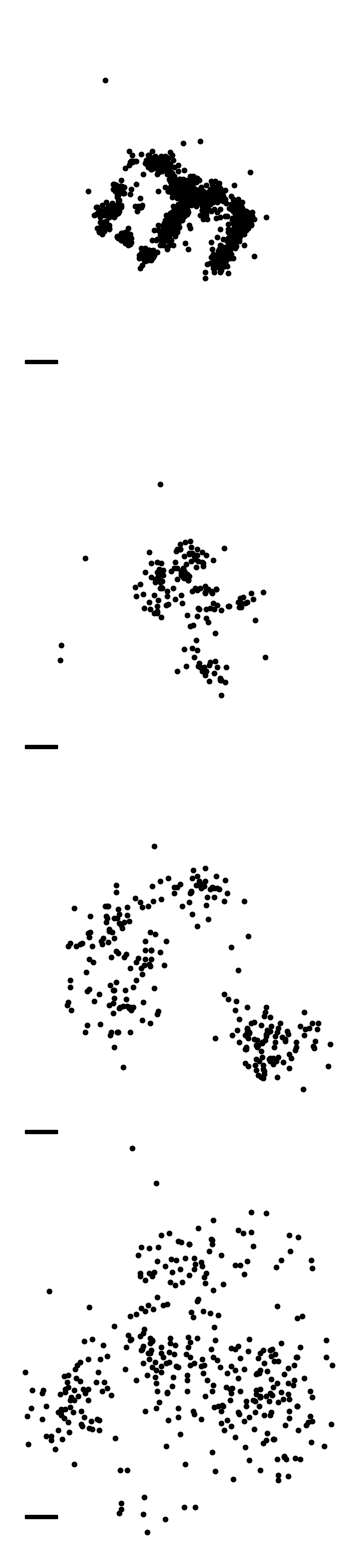

In [125]:
if not final_test:
    file_folder = "preprocessed/gt_label"
else:
    file_folder = "preprocessed/test/gt_label"
fig, ax = plt.subplots(4,1,figsize=(20,20), sharex=True, sharey=True)
for idx, file_name in enumerate(files):
    file_path = os.path.join(project_directory, file_folder, file_name + ".parquet")
    df, unique_chans = load_file(file_path, "x", "y", None, "channel")
    x = df["x"].to_numpy()
    y = df["y"].to_numpy()
    ax[idx].set_aspect('equal', adjustable='box')
    ax[idx].scatter(y, x, s=10, c='k')
    ax[idx].axis('off')
    scalebar = AnchoredSizeBar(ax[idx].transData,
                               0.1, '', 'lower left', 
                               pad=1,
                               color='k',
                               frameon=False,
                               size_vertical=0.01)

    ax[idx].add_artist(scalebar)
output_path = os.path.join(project_directory, "output", "combined" + '_raw_s_10.svg') 
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(output_path, transparent=True, bbox_inches="tight", pad_inches=0)

#### SubgraphX

In [23]:
dataitems = []
node_imps = []
for file_name in files:
    cluster_dataitem, loc_dataitem, prediction = get_prediction(
        file_name,
        cluster_model, 
        cluster_train_set, 
        loc_train_set, 
        cluster_val_set, 
        loc_val_set, 
        cluster_test_set, 
        loc_test_set,
        project_directory,
        device, 
        gt_label_map
    )
    _, _, cluster_dataitem, node_imp = subgraph_eval(cluster_model, device, subgraph_config, cluster_dataitem, prediction)
    dataitems.append(cluster_dataitem)
    node_imps.append(node_imp)

-----
Predicted label:  three
GT label:  three
Subgraphx...
Sparsity: 0.4177
Accuracy: nan
Stability: nan
Contains self loops:  True
Add/Remove edges using R button
Add/Remove positive nodes using T button
Add/Remove negative nodes using Y button


/home/oliver/smlm_cloud/locpix-points/src/locpix_points/scripts/featanalyse.py:1502: UserWarning: The edge mask is directional, meaning an edge from node 0 to 1 may be significant while an edge from 1 to 0 may not be. For visualisation we make the graph undirected and we take the maximum of two edges that connect two nodes
  warnings.warn(


Positive fidelity tensor([1.0000], device='cuda:0', grad_fn=<AbsBackward0>)
Negative fidelity tensor([5.3644e-07], device='cuda:0', grad_fn=<AbsBackward0>)
-----
Predicted label:  two
GT label:  one
Subgraphx...
Sparsity: 0.6111
Accuracy: nan
Stability: nan
Contains self loops:  True
Add/Remove edges using R button
Add/Remove positive nodes using T button
Add/Remove negative nodes using Y button


/home/oliver/smlm_cloud/locpix-points/src/locpix_points/scripts/featanalyse.py:1502: UserWarning: The edge mask is directional, meaning an edge from node 0 to 1 may be significant while an edge from 1 to 0 may not be. For visualisation we make the graph undirected and we take the maximum of two edges that connect two nodes
  warnings.warn(


Positive fidelity tensor([0.6273], device='cuda:0', grad_fn=<AbsBackward0>)
Negative fidelity tensor([0.0104], device='cuda:0', grad_fn=<AbsBackward0>)
-----
Predicted label:  L
GT label:  L
Subgraphx...
Sparsity: 0.4286
Accuracy: nan
Stability: nan
Contains self loops:  True
Add/Remove edges using R button
Add/Remove positive nodes using T button
Add/Remove negative nodes using Y button


/home/oliver/smlm_cloud/locpix-points/src/locpix_points/scripts/featanalyse.py:1502: UserWarning: The edge mask is directional, meaning an edge from node 0 to 1 may be significant while an edge from 1 to 0 may not be. For visualisation we make the graph undirected and we take the maximum of two edges that connect two nodes
  warnings.warn(


Positive fidelity tensor([0.6276], device='cuda:0', grad_fn=<AbsBackward0>)
Negative fidelity tensor([0.1731], device='cuda:0', grad_fn=<AbsBackward0>)
-----
Predicted label:  T
GT label:  L
Subgraphx...
Sparsity: 0.7791
Accuracy: nan
Stability: nan
Contains self loops:  True
Add/Remove edges using R button
Add/Remove positive nodes using T button
Add/Remove negative nodes using Y button


/home/oliver/smlm_cloud/locpix-points/src/locpix_points/scripts/featanalyse.py:1502: UserWarning: The edge mask is directional, meaning an edge from node 0 to 1 may be significant while an edge from 1 to 0 may not be. For visualisation we make the graph undirected and we take the maximum of two edges that connect two nodes
  warnings.warn(


Positive fidelity tensor([0.9971], device='cuda:0', grad_fn=<AbsBackward0>)
Negative fidelity tensor([0.0009], device='cuda:0', grad_fn=<AbsBackward0>)


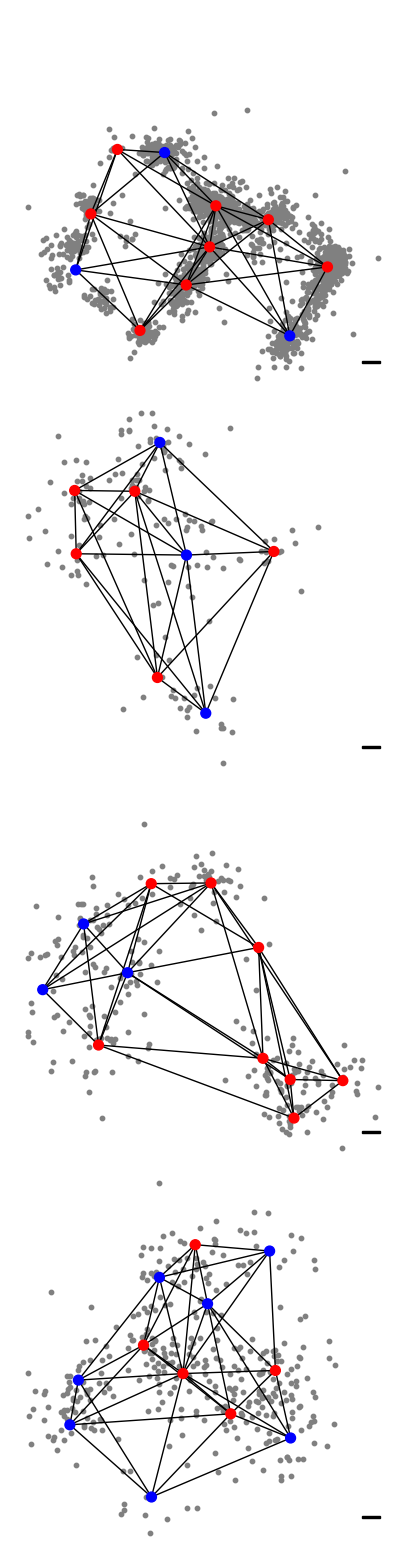

In [127]:
# visualise overlaid subgraph using matplotlib

if not final_test:
    fold = config["fold"]
    file_folder = f"processed/fold_{fold}"
else:
    file_folder = "processed"

fig, ax = plt.subplots(4,1,figsize=(20,20), sharex=True, sharey=True)
for idx, file_name in enumerate(files):
    
    file_loc = find_graph_path(project_directory, file_name, file_folder)
    # raw file
    processed_file = torch.load(file_loc)
    processed_file = processed_file.pos_dict['locs'].cpu().numpy()
    x = processed_file[:,0]
    y = processed_file[:,1]
    ax[idx].set_aspect('equal', adjustable='box')
    ax[idx].scatter(y, x, s=10, c='0.5')
    #ax[idx].axis('off')
    scalebar = AnchoredSizeBar(ax[idx].transData,
                               0.1, '', 'lower right', 
                               pad=1,
                               color='k',
                               frameon=False,
                               size_vertical=0.01)

    ax[idx].add_artist(scalebar)
    # graph
    nx_g = to_networkx(dataitems[idx], to_undirected=True)
    nx_g.remove_edges_from(nx.selfloop_edges(nx_g))
    pos = dataitems[idx].pos.cpu().numpy()
    node_color = np.where(node_imps[idx].cpu().numpy(), 'r', 'b')
    draw(nx_g, pos=np.flip(pos, axis= 1), ax=ax[idx], node_color=node_color, node_size=50)
output_path = os.path.join(project_directory, "output", "combined" + '_subgraphx_s_10.svg') 
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(output_path, transparent=True, bbox_inches="tight", pad_inches=0)


#### Attention

In [32]:
attention_config = {
    #  scale: cluster # Options: [cluster] In future will also include [loc, loccluster]
    "scale": "cluster",
    #  # how to combine attention scores across multiple attention heads
    "reduce": "max",
    # threshold to apply to edge mask for pyg explain
    "edge_mask_threshold": 0.0,
}

In [33]:
import importlib
from locpix_points.scripts import featanalyse
importlib.reload(featanalyse)

<module 'locpix_points.scripts.featanalyse' from '/home/oliver/smlm_cloud/locpix-points/src/locpix_points/scripts/featanalyse.py'>

In [34]:
dataitems_attn = []
edge_imps_attn = []
for file_name in files:
    cluster_dataitem, loc_dataitem, prediction = get_prediction(
        file_name,
        cluster_model, 
        cluster_train_set, 
        loc_train_set, 
        cluster_val_set, 
        loc_val_set, 
        cluster_test_set, 
        loc_test_set,
        project_directory,
        device, 
        gt_label_map
    )
    _, _, cluster_dataitem, edge_imp = featanalyse.attention_eval(cluster_model, attention_config, cluster_dataitem, device, loc_dataitem)
    dataitems_attn.append(cluster_dataitem)
    edge_imps_attn.append(edge_imp)

-----
Predicted label:  three
GT label:  three
Warning there are 79 non zero elements in the edge mask out of 79 elements
Post thresholding there are 24 non zero elements in the edge mask out of 79 elements
Unfaithfulness, closer to 0 better 0.9999999570560156
Can't calculate fidelity measure
-----
Predicted label:  two
GT label:  one
Warning there are 54 non zero elements in the edge mask out of 54 elements
Post thresholding there are 46 non zero elements in the edge mask out of 54 elements
Unfaithfulness, closer to 0 better 0.9999809442415426
Can't calculate fidelity measure
-----
Predicted label:  L
GT label:  L
Warning there are 77 non zero elements in the edge mask out of 77 elements
Post thresholding there are 63 non zero elements in the edge mask out of 77 elements
Unfaithfulness, closer to 0 better 0.6331018209457397
Can't calculate fidelity measure
-----
Predicted label:  T
GT label:  L
Warning there are 86 non zero elements in the edge mask out of 86 elements
Post thresholdin

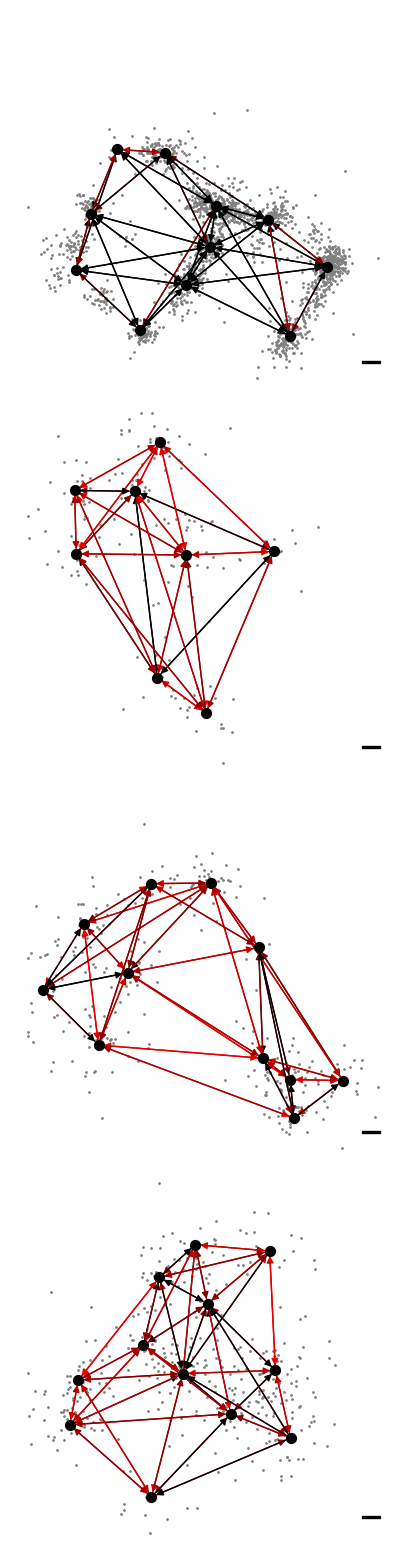

In [131]:
# visualise overlaid subgraph using matplotlib
from matplotlib.colors import LinearSegmentedColormap

if not final_test:
    fold = config["fold"]
    file_folder = f"processed/fold_{fold}"
else:
    file_folder = "processed"

colors = [(0, 0, 0), (1, 0, 0)] # first color is black, last is red
cm = LinearSegmentedColormap.from_list("br", colors)

fig, ax = plt.subplots(4,1,figsize=(20,20), sharex=True, sharey=True)
for idx, file_name in enumerate(files):
    
    file_loc = find_graph_path(project_directory, file_name, file_folder)
    # raw file
    processed_file = torch.load(file_loc)
    processed_file = processed_file.pos_dict['locs'].cpu().numpy()
    x = processed_file[:,0]
    y = processed_file[:,1]
    ax[idx].set_aspect('equal', adjustable='box')
    ax[idx].scatter(y, x, s=1, c='0.5')
    #ax[idx].axis('off')
    scalebar = AnchoredSizeBar(ax[idx].transData,
                               0.1, '', 'lower right', 
                               pad=1,
                               color='k',
                               frameon=False,
                               size_vertical=0.01)

    ax[idx].add_artist(scalebar)
    # graph
    nx_g = to_networkx(dataitems_attn[idx])
    pos = dataitems_attn[idx].pos.cpu().numpy()
    edge_color = cm(edge_imps_attn[idx].cpu())
    if 0:
        neg_edges = np.argwhere(edge_imps_attn[idx].cpu().numpy() == 0.0)
        neg_edges = np.array([e for e in nx_g.edges])[neg_edges[:,0]]
        neg_edges = [tuple(val) for val in neg_edges]
        edges = list(nx_g.edges)
        remove_indices = [i for i, item in enumerate(edges) if item in neg_edges]
        edge_color = np.delete(edge_color, remove_indices, axis=0)
        nx_g.remove_edges_from(neg_edges)
    self_loops = list(nx.selfloop_edges(nx_g))
    edges = list(nx_g.edges)
    remove_indices = [i for i, item in enumerate(edges) if item in self_loops]
    edge_color = np.delete(edge_color, remove_indices, axis=0)
    nx_g.remove_edges_from(nx.selfloop_edges(nx_g))
    if 0:
        min = np.min(edge_color[:,0])
        max = np.max(edge_color[:,0])
        edge_color[:,0] = (edge_color[:,0] - min)/(max - min)
    draw(nx_g, pos=np.flip(pos, axis= 1), ax=ax[idx], edge_color=edge_color, node_size=50, node_color='k')
output_path = os.path.join(project_directory, "output", "combined" + '_attention_all_edges_s_1.svg') 
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(output_path, transparent=True, bbox_inches="tight", pad_inches=0)